In [1]:
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 67.6 MB/s 


In [23]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import math
import os

In [4]:
images_dir = 'Training/'
file_list = os.listdir(images_dir)

In [5]:
def open_pictures(img_name):
    img_rgb = cv2.imread(img_name)
    img_gray = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    return img_rgb, img_gray

In [6]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 10))
    ax.imshow(image, cmap=cmap)
    ax.axis('off')
    return fig, ax

In [7]:
def skeletonize(image_name):
    mp_Hands = mp.solutions.hands
    hands = mp_Hands.Hands()
    img_rgb, img_gray = open_pictures(image_name)
    results = hands.process(img_rgb)
    multiLandMarks = results.multi_hand_landmarks
    return img_rgb, multiLandMarks

def get_tips_and_valleys(img_rgb, multiLandMarks):
    tips, valleys = [], []
    if multiLandMarks:
            handList = []
            for handLms in multiLandMarks:
                for idx, lm in enumerate(handLms.landmark):
                    h, w, c = img_rgb.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    handList.append((cx, cy))
                
                tips_idx = [4, 8, 12, 16, 20]
                for i in tips_idx:
                    curr, prev = handList[i], handList[i-1]
                    point = (curr[0] + (curr[0] - prev[0]) // 4, curr[1] + (curr[1] - prev[1]) // 4)
                    tips.append(point)
                valleys_idx = [5, 9, 13, 17]
                v2, v5 = handList[2], handList[5]
                valley = (v2[0] + (v5[0]-v2[0]) //3, v2[1] + (v5[1]-v2[1]) //3)
                valleys.append(valley)
                for i in range(1, len(valleys_idx)):
                    curr0, curr1 = handList[valleys_idx[i]], handList[valleys_idx[i]+1]
                    prev0, prev1 = handList[valleys_idx[i-1]], handList[valleys_idx[i-1]+1]
                    v_curr = (curr0[0] + (curr1[0] - curr0[0]) // 3, curr0[1] + (curr1[1] - curr0[1]) // 3)
                    v_prev = (prev0[0] + (prev1[0] - prev0[0]) // 3, prev0[1] + (prev1[1] - prev0[1]) // 3)
                    valley = ((v_curr[0]+v_prev[0]) //2, (v_curr[1]+v_prev[1])//2)
                    valleys.append(valley)
    return img_rgb, tips, valleys

In [8]:
def draw_lines(image, tips, valleys, file='Result.txt'):
    code = '1'
    for i in range(len(valleys)):
        start, end, far = tips[i], tips[i+1], valleys[i]
        a = math.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
        b = math.sqrt((far[0] - start[0])**2 + (far[1] - start[1])**2)
        c = math.sqrt((end[0] - far[0])**2 + (end[1] - far[1])**2)
        angle = math.acos((b**2 + c**2 - a**2) / (2*b*c)) * 57
        
        if angle < 22:
            code = code + '+' + f'{i+2}'
        else:
            code = code + '-' + f'{i+2}'
        cv2.line(image, start, far, [0, 255, 0], 2)
        cv2.line(image, far, end, [0, 255, 0], 2)
        cv2.circle(image, start, 5, [0, 0, 255], -1)
        cv2.circle(image, far, 5, [0, 0, 255], -1)
        cv2.circle(image, end, 5, [0, 0, 255], -1)
    return image, code

In [9]:
def write_file(img_name, code, tips, valleys, file='Result.txt'):
    f = open(file,'w')
    f.write(code+'\n')
    f.write(f'!,{img_name},')
    for i in range(len(tips)):
        f.write('T ' + f'{tips[i][0]}t{i+1}' + f' {tips[i][1]}t{i+1},')
    for i in range(len(valleys)):
        f.write('V ' + f'{valleys[i][0]}v{i+1}' + f' {valleys[i][1]}v{i+1},')
    f.write('?')
    f.close()

In [10]:
def process_image(images_dir, image_name, file='Result.txt'):
    img_rgb, multiLandMarks = skeletonize(images_dir+image_name)
    img_rgb, tips, valleys = get_tips_and_valleys(img_rgb, multiLandMarks)
    img_rgb, code = draw_lines(img_rgb, tips, valleys)
    write_file(image_name, code, tips, valleys, file)
    image_show(img_rgb)

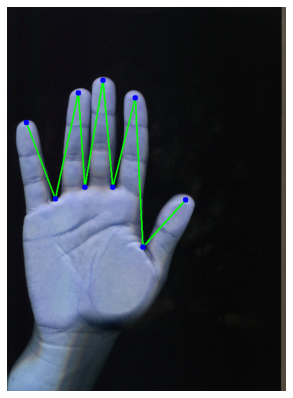

In [21]:
process_image(images_dir, '240.tif')